# 2024-04-10 · Overview figure

In [80]:
include("lib/Nto1.jl")

using Revise … ✔
using Units, Nto1AdEx, ConnectionTests, ConnTestEval, MemDiskCache … ✔
using StatsBase … ✔


## Sim

In [15]:
N = 6500
duration = 10minutes
spike_SNR = 40;

In [16]:
@time sim = Nto1AdEx.sim(N, duration);

  1.635046 seconds (21.49 k allocations: 912.268 MiB, 10.06% gc time)


In [44]:
sig = VI_sig(sim; spike_SNR);

In [45]:
include("lib/plot.jl")

import PythonCall … ✔
import PythonPlot … ✔
using Sciplotlib … ✔
using PhDPlots … ✔


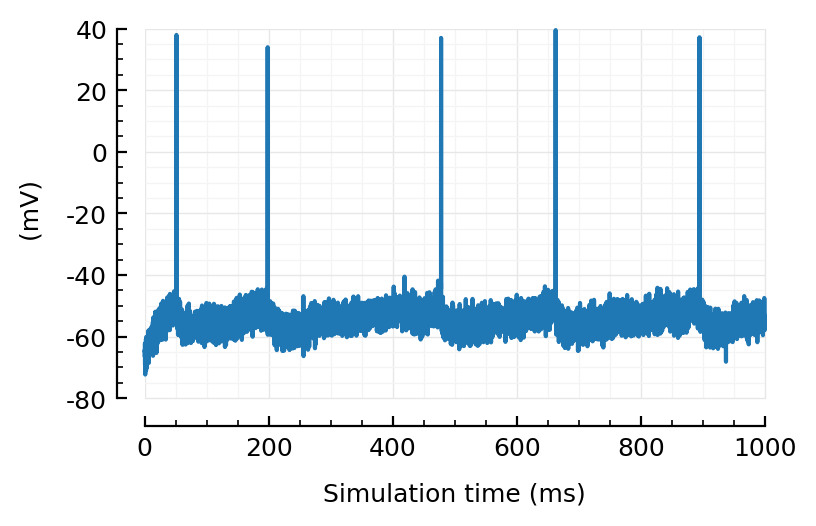

In [49]:
plotsig(sig, [0,1000], ms, yunit=:mV);

In [66]:
p = 99.9
percentile(sig, p) / mV

-42.1

In [67]:
sigc = clip!(copy(sig), p);

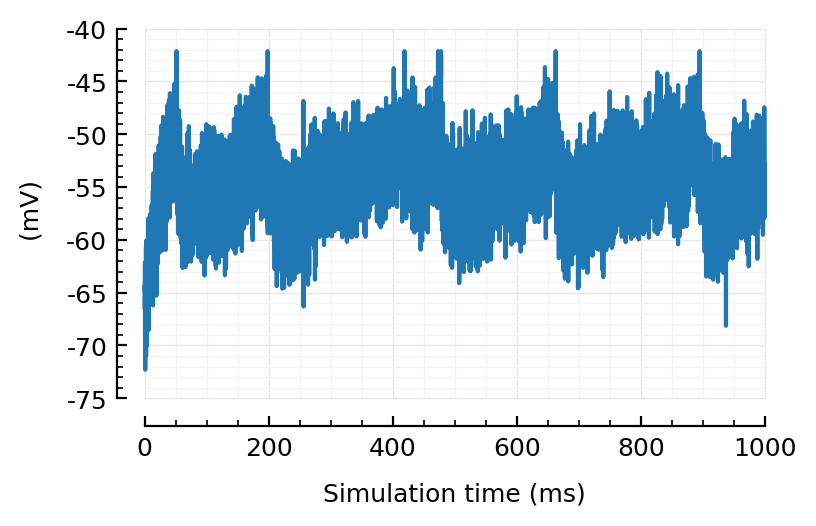

In [68]:
plotsig(sigc, [0,1000], ms, yunit=:mV);

---

Aside: Otsu-like method to find spike / clipping threshold?

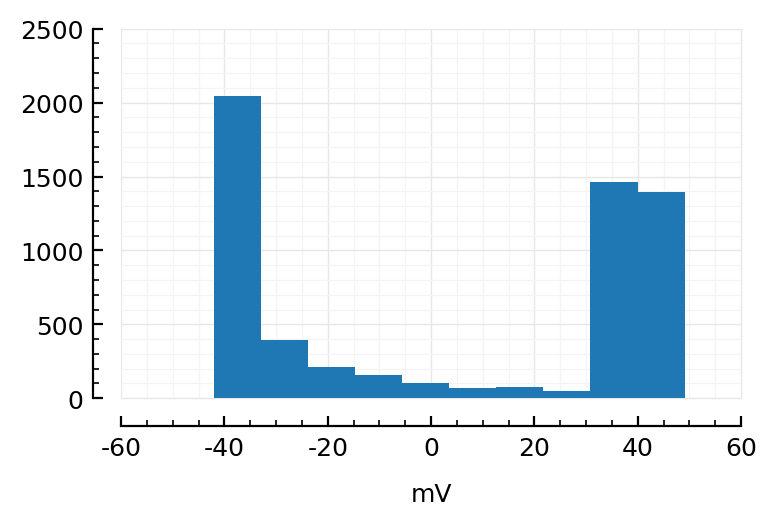

In [55]:
hist(sig[sig .> -42.1mV] / mV, xlabel="mV");

So yes it seems possible (given that our percentile is ± right..). But let's skip here and take fixed pctile value as threshold.

Although: setting all those ceiled values to e.g. 0mV is still not good (They're still peaks, so still lotsa noise added). Better if they're set to e.g. the mean (around -58 mV) or somehow excluded.

----

## Test

In [94]:
highest_firing_inputs = get_trains_to_test(sim, Nₜ=10);

In [100]:
linefit_method = ConnectionTests.FitUpstroke(
    winsize=100,  # 10 ms
    offset=0,
)
linefit_test(sig, spiketimes) = test_conn(linefit_method, sig, spiketimes);

In [102]:
conntest_methods = [
    ("STA height", STA_test),
    ("Line fit", linefit_test),
];

In [103]:
include("lib/df.jl")

using DataFrames … ✔


In [104]:
rows = []

for (method, f) in conntest_methods
    t0 = time()
    spiketrain_rows = test_inputs(sim, sigc, highest_firing_inputs, f)
    compute_time = time() - t0
    df = DataFrame(spiketrain_rows)
    sweep = sweep_threshold(df)
    row = (;
        method,
        AUC = calc_AUROCs(sweep).AUC,
        F1max = maximum(skipnan(sweep.F1)),
        compute_time,
    )
    push!(rows, row)
end

df = DataFrame(rows)

exc 100%|████████████████████████████████████████████████| Time: 0:00:03
inh 100%|████████████████████████████████████████████████| Time: 0:00:02
unc 100%|████████████████████████████████████████████████| Time: 0:00:02
exc 100%|████████████████████████████████████████████████| Time: 0:00:01
inh 100%|████████████████████████████████████████████████| Time: 0:00:00
unc 100%|████████████████████████████████████████████████| Time: 0:00:00


Row,method,AUC,F1max
,String,Float64,Float64
1,STA height,0.5,0.714
2,Line fit,0.805,0.833


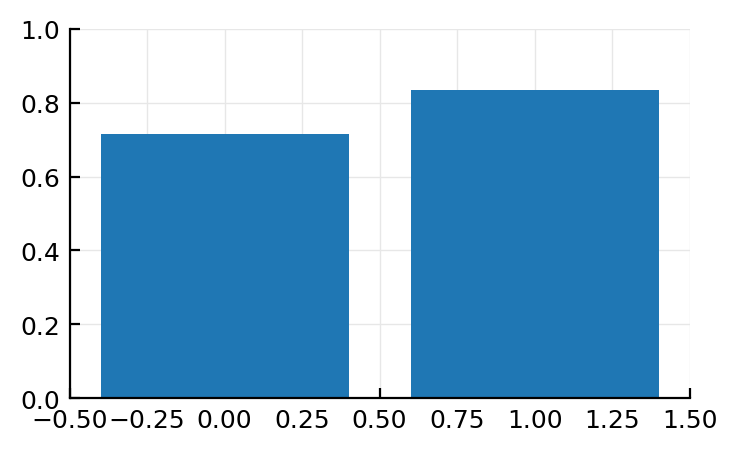

In [108]:
fig, ax = plt.subplots()
ax.bar([0, 1], df.F1max);